<h3 align="center">Computational Problem Set 7</h3> 

<h4 align="center">Kaitlyn Morrell</h4> 

In [1]:
# -*- coding: utf-8 -*-
%pylab notebook --no-import-all
%matplotlib notebook
import numpy as np
import sympy as sp
from sympy import *
import numpy.linalg as linalg
from astropy.table import Table, Column
import scipy.sparse as sparse
import scipy.sparse.linalg as linalgs
from matplotlib import animation
from IPython.display import HTML

sp.init_printing(use_latex=True, use_unicode=True)

#from __future__ import division #don't need to distinguish floats from integers for division

Populating the interactive namespace from numpy and matplotlib


### Separation of Variables

We can use the method of separation of variables to analytically solve the differential equation $$\partial_t u(x,t) - \alpha\partial^2_x u(x,t) = 0 $$ by noting $$u(x,t) = v(t)w(x)$$ which gives $$\partial_t u(x,t) = \dot{v}w(x) \text{  and  } \partial^2_x u(x,t) = w^{''}v(t) $$ Plugging this into our initial equation gives $$\dot{v}w(x)-\alpha w^{''}v(t) = 0$$ $$\dot{v}w = \alpha w^{''}v$$ $$\frac{\dot{v}}{v} = \alpha\frac{w^{''}}{w}$$ We can solve for $v(t)$ and $w(x)$ by noticing that varying $t$ cannot change the right hand side and varying $x$ cannot change the left hand side. This implies $$\frac{\dot{v}}{v} = \alpha c $$ $$\partial_t(\ln v(t)) = \alpha c$$ $$\ln v(t) = \alpha ct + K$$ $$v(t) = Ae^{\alpha ct}$$  where $c$, $K$, and $A$ are constants that depend on initial conditions. Likewise, we can find an equation for $w(x)$: $$\alpha \frac{w^{''}}{w} = c$$ $$w^{''} = \frac{c}{\alpha}w$$ This is a familiar differential equation so we will assume the ansatz $w = Be^{x\sqrt{c/\alpha}}$ and find: $$w^{''} = \frac{c}{\alpha}Be^{x\sqrt{c/\alpha}} = \frac{c}{\alpha}w$$ where $B$ and $c$ are constants determined by the boundary conditions.

### Finite Difference Method

In [2]:
class HeatProb():
    """Class for setting up a heat equation eigenvector problem"""
    def alpha(self, x=None):
        """Return alpha at x"""
        return(1.) 
    def __init__(self, N=201, **kwargs): #can put any initial inputs when call class
        self.kwargs = kwargs
        self.N = N
        self.h = 1. / (np.float64(N) + 1.)
        self.x = (np.arange(self.N, dtype=np.float64) + 1.) * self.h #do i need this h here
        diagonal = 2. * np.ones(len(self.x))
        diagonal[0] = diagonal[-1] = 0
        lower_diagonal = -1 * np.ones(len(self.x))
        upper_diagonal = -1 * np.ones(len(self.x))
        upper_diagonal[0] = lower_diagonal[-2] = 0
        self.A = (self.alpha(self.x) / self.h**2) * sparse.diags(diagonals=[lower_diagonal, diagonal, upper_diagonal],
                              offsets=[-1, 0, 1], shape=(N, N))
    def eig(self):
        # Note that the sparse version of "eig" failed here; I know this problem should 
        # yield sines and cosines. A lesson to check your package's performance! So I 
        # work on the full matrix.
        vals, vecs = linalg.eig(self.A.toarray())
        isort = np.argsort(vals)
        self.evals = vals[isort]
        self.evecs = vecs[:, isort]
    def set_coeffs(self, a=None, b=None):
        self.a = a
        self.b = b
    def fit_coeffs(self, d=None):
        """Fit coefficients for eigenvectors for a set of displacements"""
        (u, w, vt) = linalg.svd(self.evecs)
        inz = np.where(w > 1.e-15)[0]
        invw = np.zeros(len(w))
        invw[inz] = 1. / w[inz] 
        einv = vt.transpose().dot(np.diag(invw)).dot(u.transpose())
        return(einv.dot(d)) 
    def frame(self, i):
        period =  2. * np.pi / np.sqrt(self.evals[0])
        t = np.float64(i) / np.float64(nframes) * period * 4
        x = self.x
        coeffs = (self.a * np.cos(np.sqrt(self.evals) * t) +
                  self.b * np.sin(np.sqrt(self.evals) * t))
        y = self.evecs.dot(coeffs).flatten()
        line.set_data(x, y)
        return (line,)

In [2]:
class HeatProbTest():
    """Class for setting up a heat equation eigenvector problem"""
    def alpha(self, x=None):
        """Return alpha at x"""
        return(1.) 
    def __init__(self, N=201, **kwargs):
        self.kwargs = kwargs
        self.N = N
        self.h = 1. / (np.float64(N) + 1.)
        self.x = (np.arange(self.N, dtype=np.float64) + 1.) * self.h #do i need this h here
        diagonal = 2. * np.ones(len(self.x))
        lower_diagonal = -1 * np.ones(len(self.x))
        upper_diagonal = -1 * np.ones(len(self.x))
        self.A = (self.alpha(self.x) / self.h**2) * sparse.diags(diagonals=[lower_diagonal, diagonal, upper_diagonal],
                              offsets=[-1, 0, 1], shape=(N+4, N+4))
    def eig(self):
        # Note that the sparse version of "eig" failed here; I know this problem should 
        # yield sines and cosines. A lesson to check your package's performance! So I 
        # work on the full matrix.
        vals, vecs = linalg.eig(self.A.toarray())
        isort = np.argsort(vals)
        self.evals = vals[isort]
        self.evecs = vecs[:, isort]
    def set_coeffs(self, a=None, b=None):
        self.a = a
        self.b = b
    def fit_coeffs(self, d=None):
        """Fit coefficients for eigenvectors for a set of displacements"""
        (u, w, vt) = linalg.svd(self.evecs)
        inz = np.where(w > 1.e-15)[0]
        invw = np.zeros(len(w))
        invw[inz] = 1. / w[inz] 
        einv = vt.transpose().dot(np.diag(invw)).dot(u.transpose())
        return(einv.dot(d)) 
    def frame(self, i):
        period =  2. * np.pi / np.sqrt(self.evals[0])
        t = np.float64(i) / np.float64(nframes) * period * 4
        x = self.x
        coeffs = (self.a * np.cos(np.sqrt(self.evals) * t) +
                  self.b * np.sin(np.sqrt(self.evals) * t))
        y = self.evecs.dot(coeffs).flatten()
        line.set_data(x, y)
        return (line,)

In [3]:
htN = HeatProbTest(N=2)

In [101]:
x = np.arange(20, dtype=np.float64) + 1.
x[0:2] = 0
x[-2:]= 0
diagonal = -2. * x
diagonal[0] = diagonal[-1] = 0

print(diagonal, x)

(array([  0.,  -0.,  -6.,  -8., -10., -12., -14., -16., -18., -20., -22.,
       -24., -26., -28., -30., -32., -34., -36.,  -0.,   0.]), array([  0.,   0.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,   0.,   0.]))


In [3]:
ht= HeatProb()
ht.eig()
print(ht.A.toarray())

[[     0.      0.      0. ...,      0.      0.      0.]
 [-40804.  81608. -40804. ...,      0.      0.      0.]
 [     0. -40804.  81608. ...,      0.      0.      0.]
 ..., 
 [     0.      0.      0. ...,  81608. -40804.      0.]
 [     0.      0.      0. ..., -40804.  81608. -40804.]
 [     0.      0.      0. ...,      0.      0.      0.]]


In [108]:
htT= HeatProbTest()
htT.eig()
print(htT.A.toarray())

[[ 81608. -40804.      0. ...,      0.      0.      0.]
 [-40804.  81608. -40804. ...,      0.      0.      0.]
 [     0. -40804.  81608. ...,      0.      0.      0.]
 ..., 
 [     0.      0.      0. ...,  81608. -40804.      0.]
 [     0.      0.      0. ..., -40804.  81608. -40804.]
 [     0.      0.      0. ...,      0. -40804.  81608.]]


<IPython.core.display.Javascript object>


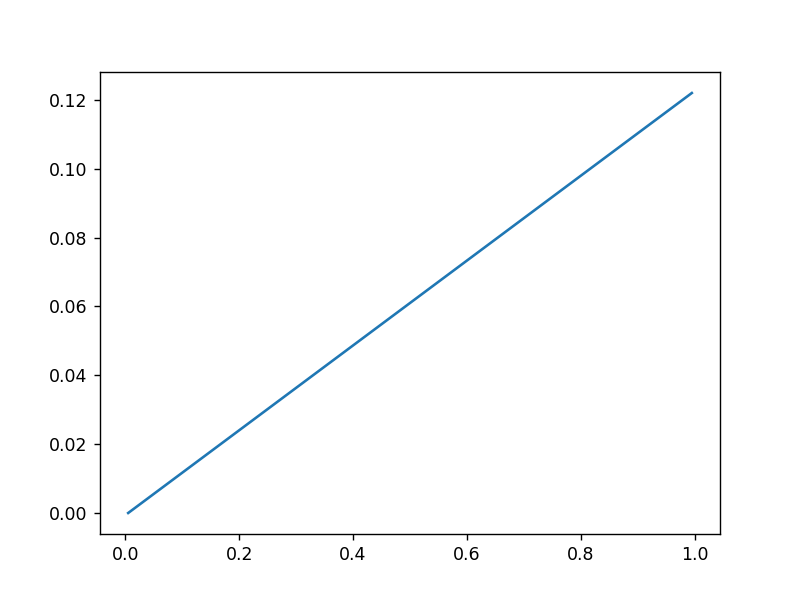

In [6]:
plt.figure()
plt.plot(ht.x, ht.evecs[:, 0])

In [9]:
plt.figure()
plt.title('Test Class')
for i in np.arange(4):
    plt.plot(htT.x, htT.evecs[:, -i], label='mode = %d' % (i))
plt.legend()

<IPython.core.display.Javascript object>

NameError: name 'htT' is not defined

<IPython.core.display.Javascript object>


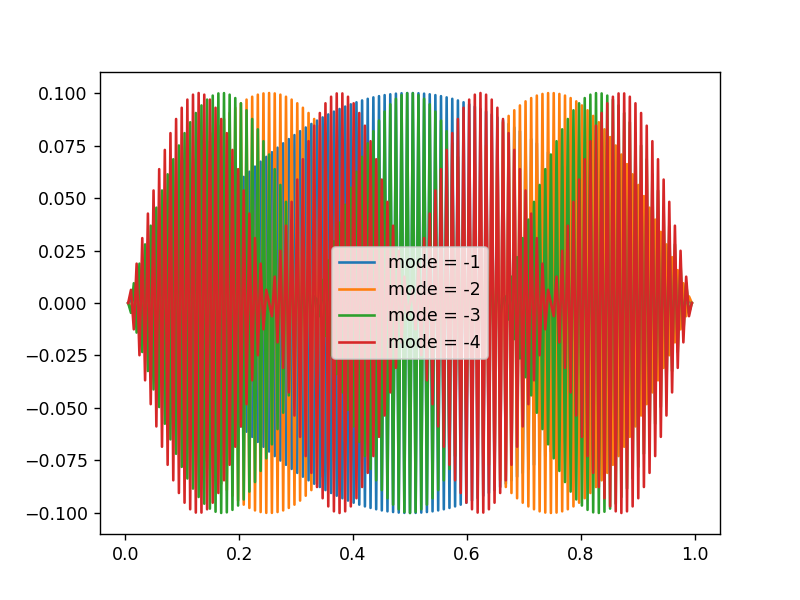

In [12]:
plt.figure()
for i in np.arange(4)+1:
    plt.plot(ht.x, ht.evecs[:, -i], label='mode = %d' % (-i))
plt.legend()